In [2]:
!pip install opencv-python

     ---------------------------------------- 38.2/38.2 MB 1.1 MB/s eta 0:00:00


In [28]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

from PIL import Image

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import re
import os
import numpy as np

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import math

In [8]:

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [9]:
#!unzip "/content/drive/MyDrive/Driver Drowsiness Dataset (DDD).zip" -d "/content/drive/MyDrive/newdata/"

In [11]:
# Add image paths, labels, file names and person IDs into lists
image_path, label, file_name, person_ID = [], [], [], []

pattern = re.compile(r'^[a-zA-Z][a-zA-Z]?') #identification criteria of participant

#data_dir = r"C:\Users\frieb\Desktop\My_Docs\RWTH\Techlab\DDD_Project\Driver_Drowsiness_Dataset_(DDD)"

path = os.getcwd()
data_dir = path + str('/Driver Drowsiness Dataset (DDD)/')

for class_name in os.listdir(data_dir):  #goes through all folders in DDD folder
  for path in os.listdir(os.path.join(data_dir, class_name)):  #goes through all files in both folders and updates file path and labels
    if class_name == 'Drowsy':
      label.append(0)
    else:
      label.append(1)
    image_path.append(os.path.join(data_dir, class_name, path))
    file_name.append(path)

    person_ID.append(pattern.findall(path)[0])  #identification of participant


#dataframe with path, label, file name, person_ID of all Persons
df = pd.DataFrame()
df['images'] = image_path
df['label'] = label
df['name'] = file_name
df['person'] = person_ID

print('df')
print(df.shape)


#add Person E and G only to the Test Dataset
dfTest = pd.concat([df[df['person']=='e'], df[df['person']=='g'], df[df['person']=='E'], df[df['person']=='G'], df[df['person']=='S'], df[df['person']=='s']])
print('dfTest')
print(dfTest.shape)


#remove Person E and G from the dataset with all Persons
dfWithout = df
dfWithout = dfWithout.drop(index=(df[df['person']=='e'].index))
dfWithout = dfWithout.drop(index=(df[df['person']=='E'].index))
dfWithout = dfWithout.drop(index=(df[df['person']=='g'].index))
dfWithout = dfWithout.drop(index=(df[df['person']=='G'].index))

dfWithout = dfWithout.drop(index=(df[df['person']=='s'].index))
dfWithout = dfWithout.drop(index=(df[df['person']=='S'].index))

print('dfWithout')
print(dfWithout.shape)


#converting imagepath and label of takeout persons G, E into an nparray
imagePathTakeout = dfTest['images']
labelTakeout = dfTest['label']

imagePathTO = np.array(imagePathTakeout).reshape([-1,1])
labelTO = np.array(labelTakeout).reshape([-1,1])
testTO = np.hstack((imagePathTO, labelTO))

print('testTO')
print(testTO.shape)


#converting imagepath and label of all other persons into an nparray
imagePathWithout = dfWithout['images']
labelWithout = dfWithout['label']

image_path = np.array(imagePathWithout).reshape([-1,1])
label = np.array(labelWithout).reshape([-1,1])
comp_data = np.hstack((image_path, label))

df
(41793, 4)
dfTest
(3514, 4)
dfWithout
(38279, 4)
testTO
(3514, 2)


In [12]:


print(testTO)
     


[['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/e0288.png'
  1]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/e0930.png'
  1]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/e0399.png'
  1]
 ...
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/s0040.png'
  1]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/s0331.png'
  1]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/s0266.png'
  1]]


In [13]:


df.groupby("person").size()
     


person
A     1411
B      315
C      335
D      179
E      962
F      415
G      499
H      508
I     1095
J      474
K      630
L      732
M      777
N     1156
O     1097
P      963
Q      562
R      204
S      487
T      933
U      420
V      653
W     1162
X     1749
Y     1112
ZA     621
ZB    1551
ZC    1346
a     1252
b      409
c      400
d     1005
e     1000
g      109
h      571
i     1045
j      717
k      538
l      381
m      473
n      957
o      671
p      190
q      521
r      522
s      457
u      510
v     1002
w      493
x     1143
y     1500
za    1054
zb    1237
zc    1288
dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

#nparray with all other persons (except of E, G) gets split into train and test dataset
trainW, testW = train_test_split(comp_data, test_size=0.2, random_state=1234)
print('trainW')
print(trainW.shape)

print('testW')
print(testW.shape)


#train dataset
train = trainW


#test dataset is a combination of the takeout of person E, G and the part that was split to test via train_test_split
test = np.concatenate((testTO, testW))


print('test')
print(test.shape)
print(train)

trainW
(30623, 2)
testW
(7656, 2)
test
(11170, 2)
[['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/A1001.png'
  0]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/za0757.png'
  1]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Non Drowsy/y1428.png'
  1]
 ...
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/O1375.png'
  0]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/A1339.png'
  0]
 ['/rwthfs/rz/cluster/home/ko617013/techlabs/Driver Drowsiness Dataset (DDD)/Drowsy/W0637.png'
  0]]


In [15]:
## https://github.com/zekeriyafince/EyePair/blob/master/haar-cascade/haarcascades_haarcascade_mcs_eyepair_big.xml
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') # face 

## https://github.com/zekeriyafince/EyePair/blob/master/haar-cascade/haarcascade_frontalface_default.xml
eyePair_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml') #eye_pair

defaultPicture = np.zeros((60,150,1)) # black picture
c=0

def ReturnEyePairFunc(frameImage):
    #print("here")
    gray = cv2.cvtColor(frameImage, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 1)
    #print("gray", gray.shape)


    for x, y, w, h in faces: # face points
        roiGray = gray[y:y + h, x:x + w]
        roiColor = frameImage[y:y + h, x:x + w]
        eyePairs = eyePair_cascade.detectMultiScale(roiGray)

        if(len(eyePairs)==2):
        
            ex1,ey1,ew1,eh1 = eyePairs[0][0],eyePairs[0][1],eyePairs[0][2],eyePairs[0][3]
            ex2,ey2,ew2,eh2 = eyePairs[1][0],eyePairs[1][1],eyePairs[1][2],eyePairs[1][3]

            ex_min = min(ex1, ex2)
            ex_max = max(ex1, ex2)
            ey_min = min(ey1, ey2)
            ey_max = max(ey1, ey2)
            ew_max = max(ew1, ew2)
            eh_max = max(eh1, eh2)
            #print(ex1,ey1,ew1,eh1)
            #print(ex2,ey2,ew2,eh2)
            roiEyes = roiGray[ ey_min: ey_max + eh_max, ex_min:ex_max + ew_max ]
            #print("roiEyes", roiEyes.shape)
            
            #plt.imshow(roiEyes)

            return roiEyes
    #c=c+1
    return defaultPicture

In [16]:
class DDDdataset(Dataset):




  def __init__(self, image_paths, image_labels, transform):
    super().__init__()
    self.paths = image_paths
    self.labels = image_labels
    self.len = len(self.paths)
    self.transform = transform
  
  def __len__(self): return self.len
  
  def __getitem__(self, index):
    path = self.paths[index]
    label = self.labels[index]
    target_tensor=torch.from_numpy(np.array(label,dtype=np.int16))
    #image = Image.open(path).convert('RGB')
    image = cv2.imread(path,cv2.IMREAD_UNCHANGED)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #print("1", image.shape)
    image = ReturnEyePairFunc(image)
    #print("2", image.shape)
    image = self.transform(image)
    #print("3",image.shape)
    #image = image.reshape((image.shape[1], image.shape[2], -1))
    #print("4",image.shape)
    #plt.imshow(image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    return (image, target_tensor, path)
  



 

In [17]:
# path = df['images'][index]
# label = df['label'][index]
# target_tensor=torch.from_numpy(np.array(label,dtype=np.int16))
# #image = Image.open(path).convert('RGB')
# image = cv2.imread(path,cv2.IMREAD_UNCHANGED)
# #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# #print("1", image.shape)
# image = ReturnEyePairFunc(image)
# #print("2", image.shape)
# image = transformation(image)
# #print("3",image.shape)
# image = image.reshape((image.shape[1], image.shape[2], -1))
# #print("4",image.shape)
# plt.imshow(image)
# #cv2.waitKey(0)
# #cv2.destroyAllWindows()
# return (image, target_tensor, path)

In [18]:
meanR = 0.006185
meanG = 0.006140
meanB = 0.006088
stdR = 0.06234
stdG = 0.06194
stdB = 0.06151

In [19]:
#transformation for model training and testing
transformation_1 = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[meanR, meanG, meanB], std=[stdR, stdG, stdB])
    transforms.Resize((60, 150)),
    #transforms.Normalize(mean=[meanR], std=[stdR])
])



#datasets and dataloaders for model training and testing
trainDataset = DDDdataset(train[:,0], train[:,-1], transformation_1)
#testDataset = DDDdataset(test[:,0], test[:,-1], transformation_1)

trainDataLoader = DataLoader(trainDataset, batch_size=len(trainDataset), num_workers = 8) #, shuffle=True)
#testDataLoader = DataLoader(testDataset, batch_size=64, shuffle=True)

data = next(iter(trainDataLoader))

print(data[0].mean(), data[0].std())

#batch_idx, (data, target) = next(enumerate(trainDataLoader))

tensor(0.1527, dtype=torch.float64) tensor(0.2228, dtype=torch.float64)


In [ ]:
mean = 0.1520
std = 0.2226

In [ ]:
#transformation for model training and testing
transformation_2 = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[meanR, meanG, meanB], std=[stdR, stdG, stdB])
    transforms.Resize((60, 150)),
    transforms.Normalize(mean=mean, std=std)
])



#datasets and dataloaders for model training and testing
trainDataset = DDDdataset(train[:,0], train[:,-1], transformation_2)
testDataset = DDDdataset(test[:,0], test[:,-1], transformation_2)

trainDataLoader = DataLoader(trainDataset, batch_size=64, shuffle=True, num_workers = 8)
testDataLoader = DataLoader(testDataset, batch_size=64, shuffle=True, num_workers = 8)



#batch_idx, (data, target) = next(enumerate(trainDataLoader))

In [22]:

"""
--------------------------------
number of parameters CNN below

(II) f*f*ch_in*ch_out + ch_out_bias = params_conv_layer

(III) numberOfInputImageElements*outputFeaturesCurrentFCLayer = params_fully_connected

conv1: 4*4*3*10 + 10 = 490 -> 4*4 filter, 3 input image channels, 10 number of filters, +10 bias parameters of each filter
conv2: 5*5*10*20 + 20 = 5020
conv3: 6*6*20*32 + 32 = 23072
conv4: 3*3*32*40 + 40 = 11560

after conv4 layer: output "image": 3*3*40 = 360

fc1: 360*50 + 50 = 18050 -> fc1 has 50 output features
fc2: 50*20 + 20 = 1020
fc3: 20*2 + 2 = 42

complete CNN: 59254 parameters
"""

'\n--------------------------------\nnumber of parameters CNN below\n\n(II) f*f*ch_in*ch_out + ch_out_bias = params_conv_layer\n\n(III) numberOfInputImageElements*outputFeaturesCurrentFCLayer = params_fully_connected\n\nconv1: 4*4*3*10 + 10 = 490 -> 4*4 filter, 3 input image channels, 10 number of filters, +10 bias parameters of each filter\nconv2: 5*5*10*20 + 20 = 5020\nconv3: 6*6*20*32 + 32 = 23072\nconv4: 3*3*32*40 + 40 = 11560\n\nafter conv4 layer: output "image": 3*3*40 = 360\n\nfc1: 360*50 + 50 = 18050 -> fc1 has 50 output features\nfc2: 50*20 + 20 = 1020\nfc3: 20*2 + 2 = 42\n\ncomplete CNN: 59254 parameters\n'

In [23]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=(2,2), stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(5)
    self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(3,3), stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(10)
    # self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(6,6), stride=2, padding=1)
    # self.bn3 = nn.BatchNorm2d(32)
    # self.conv4 = nn.Conv2d(in_channels=32, out_channels=40, kernel_size=(3,3), stride=1, padding=1)
    # self.bn4 = nn.BatchNorm2d(40)

    self.fc1 = nn.Linear(in_features=270, out_features=15)
    self.bn5 = nn.BatchNorm1d(15)
    self.fc2 = nn.Linear(in_features=15, out_features=5)
    self.bn6 = nn.BatchNorm1d(5)
    self.fc3 = nn.Linear(in_features=5, out_features=2)

  def forward(self, X):

    X = F.relu(self.bn1(self.conv1(X)))

    X = F.max_pool2d(X, 2)

    X = F.relu(self.bn2(self.conv2(X)))

    X = F.max_pool2d(X, 2)

    #X = F.relu(self.bn3(self.conv3(X)))

    #X = F.max_pool2d(X, 3, stride=2)
    X = F.max_pool2d(X, 2)

    # X = F.relu(self.bn4(self.conv4(X)))

    # X = F.max_pool2d(X, 2)

    X = X.view(X.shape[0], -1)
    X = F.relu(self.bn5(self.fc1(X)))
    X = F.relu(self.bn6(self.fc2(X)))
    X = self.fc3(X)

    return X


In [29]:
#MODEL TRAINING AND TESTING

import time

#basic settings
model = CNN().to(device)
number_epochs = 4
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []         # for plotting 
accuracies = []      # for plotting
test_losses = []    # for plotting
test_accuracies = []   # for plotting


f1score_list = []
f1score_test_list = []


#for the analysis of the wrong classifications
pathsOfWrongClassifications = []
rowsOfWrongClassifications = []
correctLabel = []
epochOfWrongClassification = []


start = time.time()
#model training and testing process
for epoch in range(number_epochs):
    
    
  train_preds = []       # for f1score
  test_preds_list = []   # for f1score

  train_class = []     # for f1score
  test_class = []      # for f1score

  epoch_loss = 0
  epoch_accuracy = 0
  
  #-------model training-------
  for (X, y, path) in trainDataLoader:
    X = X.float().to(device) #torch.as_tensor(X)
    y = y.to(device) #torch.as_tensor(y)
    
    train_class.extend(y.cpu().tolist())   #adds all the true labels in the batches in each epoch to the list
    
    predictions = model(X)
    
    
    pred_class = predictions.argmax(dim=1)         ##finding predicted class labels for f1score
    train_preds.extend(pred_class.cpu().tolist())    #adds all the predicted labels in the batches in each epoch to the list
    
    
    
    loss = loss_func(predictions, y.long())

    #adaption of the neural network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #
    accuracy = ((predictions.argmax(dim=1) == y).float().mean())
    
    #epoch_accuracy and epoch_loss as it is being plotted cannot be tensor on cuda or have requiresgrad=True 
    epoch_accuracy += accuracy.cpu().detach().numpy()   
    epoch_loss += loss.cpu().detach().numpy()
  
  #total epoch_accuracy and epoch_loss calculation
  epoch_accuracy = epoch_accuracy/len(trainDataLoader)
  accuracies.append(epoch_accuracy)
  epoch_loss = epoch_loss / len(trainDataLoader)
  losses.append(epoch_loss)
  
  # calculating f1_score in train
  f1score = f1_score(train_preds, train_class, average = 'weighted')
  f1score_list.append(f1score)
    
  print("\n --- Epoch: {}, train loss: {:.4f}, train acc: {:.4f}, f1 score: {:.4f},  time: {}".format(epoch, epoch_loss, epoch_accuracy, f1score, time.time() - start))
  #-------model training-------
  
  
  #---model testing---
  model.eval() #sets the model in evaluation mode
  
  #with disabled gradient calculation
  with torch.no_grad():
    test_epoch_loss = 0
    test_epoch_accuracy = 0

    for test_X, test_y, path in testDataLoader:

      test_X = test_X.float().to(device)
      test_y = test_y.to(device)
        
      test_class.extend(test_y.cpu().tolist())   #adds all the true labels in the batches in each epoch to the list

      test_preds = model(test_X)
      
      test_pred_class = test_preds.argmax(dim=1)    #finding predicted class labels for f1score  
      test_preds_list.extend(test_pred_class.cpu().tolist())   #adds all the predicted labels in the batches in each epoch to the list
    
    
      test_loss = loss_func(test_preds, test_y.long())
      
      
        
      test_epoch_loss += test_loss.cpu().numpy()            
      test_accuracy = ((test_preds.argmax(dim=1) == test_y).float().mean())
      test_epoch_accuracy += test_accuracy.cpu().numpy()

      #if test prediction is wrong save the path of the image that has been classified wrong
      for index, row in enumerate(test_preds):
        if row.argmax(dim=0) != test_y[index]:
          pathsOfWrongClassifications.append(path[index])
          if rowsOfWrongClassifications == []:
            row = row.cpu()
            rowsOfWrongClassifications = row
          else:
            row = row.cpu()
            rowsOfWrongClassifications = np.vstack([rowsOfWrongClassifications, row])
          correctLabel.append(test_y[index].item())
          epochOfWrongClassification.append(epoch)

    #total test_epoch_accuracy and test_epoch_loss calculation
    
    test_epoch_accuracy = test_epoch_accuracy/len(testDataLoader)
    test_accuracies.append(test_epoch_accuracy)   #for plotting
    
    test_epoch_loss = test_epoch_loss / len(testDataLoader)
    test_losses.append(test_epoch_loss)           #for plotting
    
    f1score_test = f1_score(test_preds_list, test_class, average = 'weighted')
    f1score_test_list.append(f1score_test)
    print("Epoch: {}, test loss: {:.4f}, test acc: {:.4f}, f1score: {:.4f}, time: {}\n".format(epoch, test_epoch_loss, test_epoch_accuracy,f1score_test, time.time() - start))
  #---model testing---

  model.train(mode=True) #sets the model back in training mode


 --- Epoch: 0, train loss: 0.5324, train acc: 0.6847, f1 score: 0.7215,  time: 142.01430249214172


/w0/tmp/slurm_ko617013.34294859/ipykernel_546948/1480254234.py:117: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if rowsOfWrongClassifications == []:


Epoch: 0, test loss: 0.5734, test acc: 0.6695, f1score: 0.6985, time: 194.47144889831543


 --- Epoch: 1, train loss: 0.4628, train acc: 0.7104, f1 score: 0.7380,  time: 336.72343921661377


/w0/tmp/slurm_ko617013.34294859/ipykernel_546948/1480254234.py:117: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if rowsOfWrongClassifications == []:


Epoch: 1, test loss: 0.7035, test acc: 0.6768, f1score: 0.7203, time: 389.9188902378082


 --- Epoch: 2, train loss: 0.4478, train acc: 0.7152, f1 score: 0.7430,  time: 533.8282997608185


/w0/tmp/slurm_ko617013.34294859/ipykernel_546948/1480254234.py:117: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if rowsOfWrongClassifications == []:


Epoch: 2, test loss: 0.7694, test acc: 0.6455, f1score: 0.6937, time: 586.0424385070801


 --- Epoch: 3, train loss: 0.4426, train acc: 0.7180, f1 score: 0.7447,  time: 728.6440539360046


/w0/tmp/slurm_ko617013.34294859/ipykernel_546948/1480254234.py:117: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if rowsOfWrongClassifications == []:


Epoch: 3, test loss: 0.7339, test acc: 0.6710, f1score: 0.7159, time: 780.771785736084



In [30]:
#np_rows = np.array(rowsOfWrongClassifications)

#extract the person ID out of the stored image paths
personID = []
for pathStr in pathsOfWrongClassifications:
  personID.append(pathStr[pathStr.rfind('/')+1:-8])


#create a dataframe from all wrong classified images in the test dataset
dfWrong = pd.DataFrame()
dfWrong['testEpochNo'] = epochOfWrongClassification
dfWrong['personID'] = personID
dfWrong['imagepath'] = pathsOfWrongClassifications
dfWrong['correctLabel'] = correctLabel
dfWrong['outputValueLabel0'] = rowsOfWrongClassifications[:,0]
dfWrong['outputValueLabel1'] = rowsOfWrongClassifications[:,1]

print(dfWrong)

       testEpochNo personID  \
0                0        r   
1                0        y   
2                0        h   
3                0        p   
4                0        k   
...            ...      ...   
14935            3        y   
14936            3        h   
14937            3        n   
14938            3        v   
14939            3        e   

                                               imagepath  correctLabel  \
0      /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...             1   
1      /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...             1   
2      /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...             1   
3      /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...             1   
4      /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...             1   
...                                                  ...           ...   
14935  /rwthfs/rz/cluster/home/ko617013/techlabs/Driv...             1   
14936  /rwthfs/rz/cluster/home/ko61

In [31]:
#get an overview of the persons that are likely to be classified in a wrong way
dfOfEpoch2 = dfWrong[dfWrong['testEpochNo']==2]
dfOfEpoch2.groupby('personID').size()

personID
E     267
G       5
S      23
ZB      2
ZC      5
a     193
b      41
c      68
d      58
e     877
g     109
h     104
i      35
j      33
k      75
l      45
m      54
n     220
o      31
p      30
q      82
r      84
s     457
u      75
v     154
w     102
x      94
y     186
za     56
zb    146
zc    244
dtype: int64

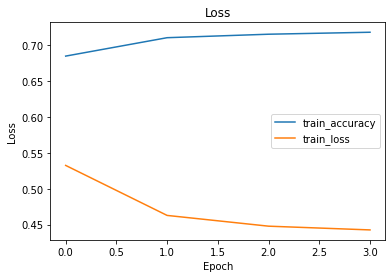

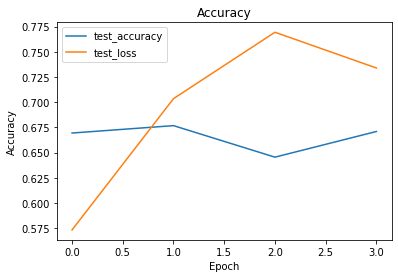

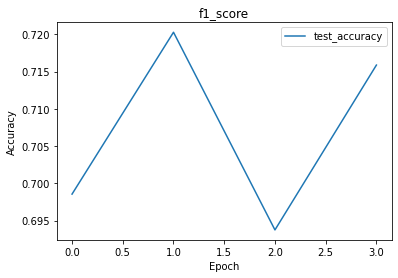

In [32]:
# plot loss
plt.plot(accuracies, label='train_accuracy')
plt.plot(losses, label='train_loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot accuracy
plt.plot(test_accuracies, label='test_accuracy')
plt.plot(test_losses, label='test_loss')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


#f1_score
plt.plot(f1score_test_list, label='test_accuracy')
#plt.plot(test_losses, label='test_loss')
plt.legend()
plt.title('f1_score')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [33]:
cm = confusion_matrix(test_preds_list, test_class)
print(cm)

[[5901 3525]
 [ 152 1592]]
